# TreeView Simulations

In [1]:
import datetime
import xarray
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import os
import pandas as pd
import json
import seaborn

from pyeosim.atmosphere import LUT_from_file
from pyeosim.datasets import DATA_PATHS

def hist2d(ds, lims=(0,1), n_bins=20):
    h = np.empty((len(im.wavelength), n_bins))
    _im = ds
    for i in range(len(im.wavelength)):

        h[i,:] = np.histogram(_im.isel(wavelength=i).values.ravel(),
                              bins=np.linspace(lims[0],lims[1],n_bins+1))[0]
    return h

def read_atmos_meta(path):
    jsons = os.listdir(path)
    jsons = [x for x in os.listdir(atmos_path) if x.endswith('json')]
    metas = {}
    for _json in jsons:
        with open(os.path.join(path, _json), 'r') as f:
            metas[_json.split('.')[0]] = json.load(f)
    return pd.DataFrame(metas).T

# load and preprocess imagery 
fpath = DATA_PATHS['TEST_HSI_LARGE']
im = xarray.open_dataset(fpath).Reflectance
im = im.swap_dims({'band':'wavelength'})
im = im.sel(wavelength=slice(400,898)).astype(float)/10000

## 1. Input Reflectances

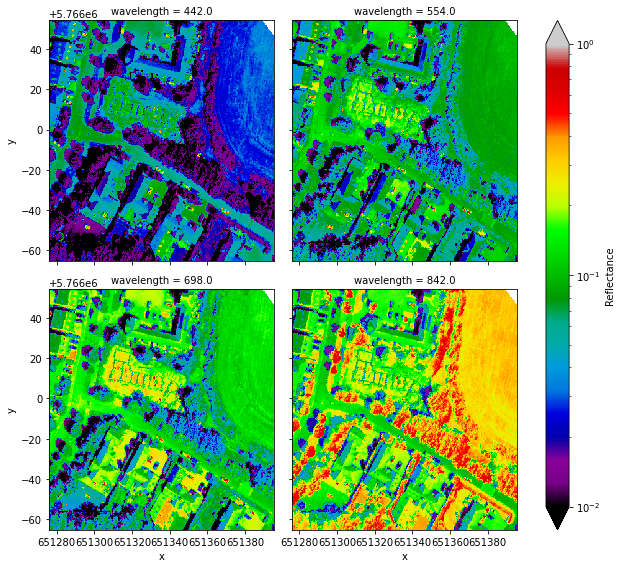

In [2]:
ax = im.isel(wavelength=[10, 45, 90, 135]).plot(col="wavelength",
                                                col_wrap=2,
                                                robust=False,
                                                size=4,
                                                cmap='nipy_spectral', norm=LogNorm(.01,vmax=1))
plt.savefig('TreeView_plots/1_input_reflectance.png', DPI=300)

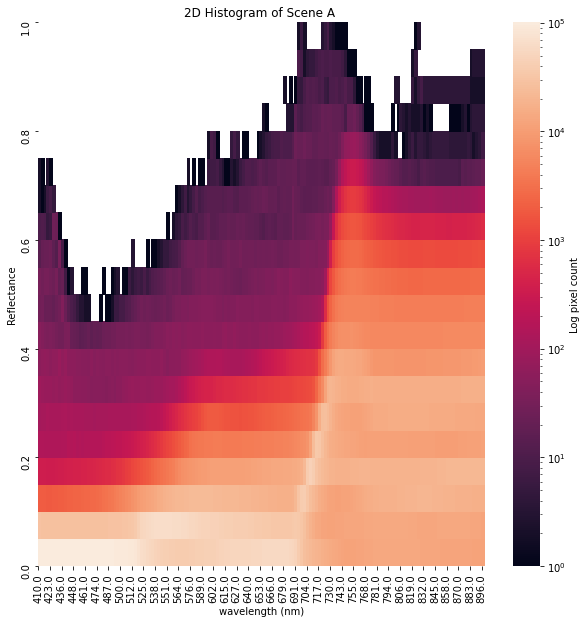

In [3]:
reflectance_histogram = hist2d(im)
f, ax = plt.subplots(1, figsize=(10,10))
seaborn.heatmap(reflectance_histogram.T, ax=ax,
                norm=LogNorm(), cbar_kws={'label':'Log pixel count'})
plt.yticks(ticks=np.arange(21)[::4], labels=np.linspace(0,1,21).round(1)[::4])
plt.xticks(ticks=np.arange(len(im.wavelength))[::4], labels=im.wavelength.values[::4])
ax.invert_yaxis()
plt.xlabel('wavelength (nm)')
plt.ylabel('Reflectance')
plt.title('2D Histogram of Scene A ')
plt.savefig('TreeView_plots/2_input_reflectance_histogram.png', DPI=300)

## 2. Input Radiances

Text(0.5, 1.0, 'LNT: 10.30')

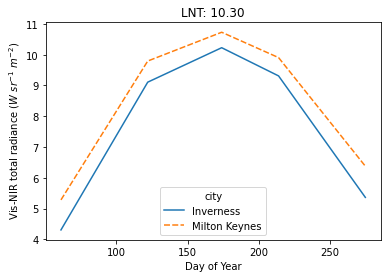

In [4]:
atmos_path = 'atmospheres/atmospheres_2/'
atmos_meta = read_atmos_meta(atmos_path)
atmos = LUT_from_file(atmos_path, {
    'view_z': 0,
    'view_a': 0
})
# atmos = Test6S()
# # generate Top of Atmosphere images
TOA = atmos.transform(im).compute()
TOA_ref = atmos.transform(xarray.ones_like(im))

# calculate metadata params
atmos_meta['sensor_radiance'] = TOA.mean(['x','y']).integrate('wavelength')
atmos_meta['city'] = ['Inverness']*6 + ['Milton Keynes'] *6
# drop the midday estimates 
atmos_meta = atmos_meta.drop(['mk_20200622_1200_nadir','inv_20200622_1200_nadir'])
# get day of year for plotting
atmos_meta['date'] = atmos_meta.apply(lambda x: datetime.datetime(2020,
                                                                  x['month'],
                                                                  x['day']), axis=1)
atmos_meta['DOY']= atmos_meta.date.dt.dayofyear
atmos_meta.drop(atmos_meta.columns[14:34], axis=1).to_csv('TreeView_data/1_atmospheric_params.csv')
seaborn.lineplot(data=atmos_meta, x='DOY', y='sensor_radiance', hue='city',style='city')
plt.ylabel(r' Vis-NIR total radiance $(W~sr^{-1}~m^{-2})$')
plt.xlabel('Day of Year')
plt.title('LNT: 10.30')
# plt.savefig('TreeView_plots/3_integrated_sensor_radiance.png', DPI=300)

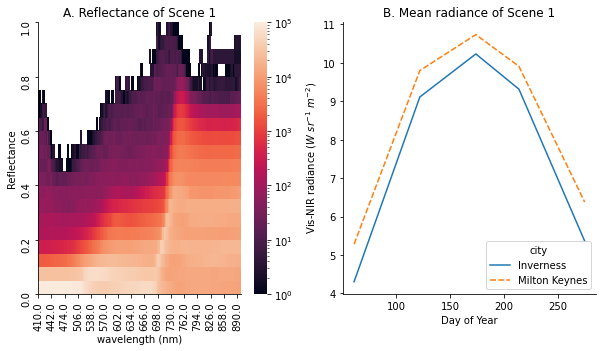

In [5]:
f, ax = plt.subplots(ncols=2, figsize=(10,5))
seaborn.heatmap(reflectance_histogram.T, ax=ax[0],
                norm=LogNorm(), cbar_kws={'label':''},)


ax[0].set_yticks(ticks=np.arange(21)[::4])
ax[0].set_yticklabels(np.linspace(0,1,21).round(1)[::4])

ax[0].set_xticks(ticks=np.arange(len(im.wavelength))[::10])
ax[0].set_xticklabels(labels=im.wavelength.values[::10])
ax[0].invert_yaxis()
ax[0].set_xlabel('wavelength (nm)')
ax[0].set_ylabel('Reflectance')
ax[0].set_title('A. Reflectance of Scene 1')

seaborn.lineplot(data=atmos_meta, x='DOY', y='sensor_radiance', hue='city',style='city', ax=ax[1])
ax[1].set_xlabel('Day of Year')
ax[1].set_ylabel(r' Vis-NIR radiance $(W~sr^{-1}~m^{-2})$')
seaborn.despine()
ax[1].set_title('B. Mean radiance of Scene 1')
plt.savefig('TreeView_plots/3_integrated_sensor_radiance.png')

## 3. Spectral bandpass responses

In [6]:
from pyeosim.spectral import TreeView_1, TreeView_2, Sentinel2VNIR, SuperDove
cmap1=['blue', 'darkturquoise', 'limegreen', 'darkgreen', 'orange', 'deeppink', 'red','brown','grey', 'k']

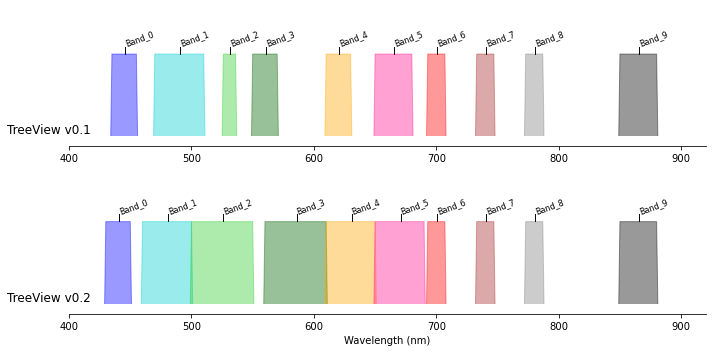

In [7]:
f, axs = plt.subplots(nrows=2, figsize=(10,5))
alt_bnames = ['Band_{}'.format(x) for x in range(10)]
ymax = .7
# Plot bands
###################### Sentinel
# srf = Sentinel2VNIR()

# ax = axs[0]
# for n, c in zip(srf.band_names,
#                 ['blue', 'darkgreen', 'red', 'darkred','brown','grey', 'k', 'k']):
#     ax.fill_between(x=srf.srfs[n].wavelength, y1=srf.srfs[n].values*ymax,color=c, alpha=.4)
# ax.set_ylim(.01,1.1)
# ax.set_xlim(400,920)
# # plt.legend()

# ax.set_yticks([])
# ax.set_ylabel('')
# for wlen, name in zip(srf.band_wavelengths.values(), alt_bnames):
#     ax.annotate(name, (wlen,ymax*1.1), rotation=20, fontsize=8)
#     ax.annotate('I', (wlen,ymax*1), rotation=0)
# ax.set_ylabel('Sentinel-2',rotation=0, y=0, fontsize=12, labelpad=20)
# ax.set_xticks([])

# ###################### Superdove
# ax = axs[1]
# srf = SuperDove()
# ax.set_xticks([])
# for n, c in zip(srf.band_names,
#                 ['blue', 'aqua', 'lime', 'darkgreen', 'orange', 'red', 'darkred','k']):
#     ax.fill_between(x=srf.srfs[n].wavelength, y1=srf.srfs[n].values*ymax,color=c, alpha=.4)
# ax.set_ylim(.01,1.1)
# ax.set_xlim(400,920)
# # plt.legend()

# ax.set_yticks([])
# ax.set_ylabel('')

# for wlen, name in zip(srf.band_wavelengths.values(), alt_bnames):
#     ax.annotate(name, (wlen,ymax*1.1), rotation=20, fontsize=8)
#     ax.annotate('I', (wlen,ymax*1), rotation=0)
# ax.set_ylabel('Superdove',rotation=0, y=0, fontsize=12, labelpad=20)
# ax.set_xticks([])


###################### TreeView
ax = axs[0]
srf = TreeView_1()

for n, c in zip(srf.band_names,
                cmap1):
    ax.fill_between(x=srf.srfs[n].wavelength, y1=srf.srfs[n].values*ymax,color=c, alpha=.4)
ax.set_ylim(.01,1.1)
ax.set_xlim(400,920)

ax.set_yticks([])
ax.set_ylabel('TreeView v0.1',rotation=0, y=0, fontsize=12, labelpad=20)

for wlen, name in zip(srf.band_wavelengths.values(), alt_bnames):
    ax.annotate(name, (wlen,ymax*1.1), rotation=20, fontsize=8, color='k')
    ax.annotate('I', (wlen,ymax*1), rotation=0, color='k')

###################### TreeView 2
ax = axs[1]
srf = TreeView_2()

for n, c in zip(srf.band_names,
                cmap1):
    ax.fill_between(x=srf.srfs[n].wavelength, y1=srf.srfs[n].values*ymax,color=c, alpha=.4)
ax.set_ylim(.01,1.1)
ax.set_xlim(400,920)

ax.set_yticks([])
ax.set_ylabel('TreeView v0.2',rotation=0, y=0, fontsize=12, labelpad=20)

for wlen, name in zip(srf.band_wavelengths.values(), alt_bnames):
    ax.annotate(name, (wlen,ymax*1.1), rotation=20, fontsize=8, color='k')
    ax.annotate('I', (wlen,ymax*1), rotation=0, color='k')

ax.set_xlabel('Wavelength (nm)')

seaborn.despine(left=True, offset=10)
plt.tight_layout()
plt.savefig('TreeView_plots/4_sensor_comparison.png')

## 4. Band-integrated irradiances

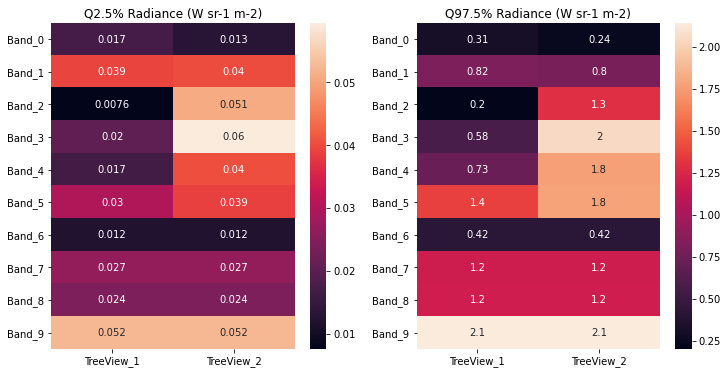

In [8]:
BII = []
# for s in [TreeView_1(), TreeView_2(), Sentinel2VNIR(), SuperDove()]:
#     BII.append(s.transform(TOA))
    
for s in [TreeView_1(), TreeView_2()]:
    BII.append(s.transform(TOA))
    
BII = xarray.concat(BII, dim='sensor').assign_coords({'sensor':['TreeView_1',
                                                                'TreeView_2']})
BII = BII.assign_coords({'band':alt_bnames})

f, ax=plt.subplots(ncols=2,figsize=(12,6))
seaborn.heatmap(BII.quantile(.025,['x','y','scenario']).to_pandas().T,ax=ax[0], annot=True)
ax[0].set_title('Q2.5% Radiance (W sr-1 m-2)')
ax[0].set_ylabel('')
ax[0].set_xlabel('')

seaborn.heatmap(BII.quantile(.975,['x','y','scenario']).to_pandas().T, ax=ax[1], annot=True)
ax[1].set_title('Q97.5% Radiance (W sr-1 m-2)')
ax[1].set_ylabel('')
ax[1].set_xlabel('')

plt.savefig('TreeView_plots/5_minMax_radiance.png')

Text(0.5, 1.0, 'NDVI | Atmosphere_1')

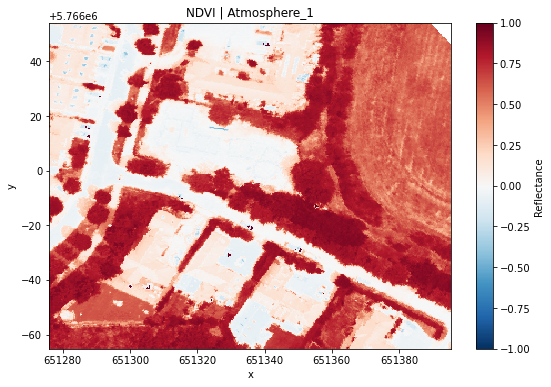

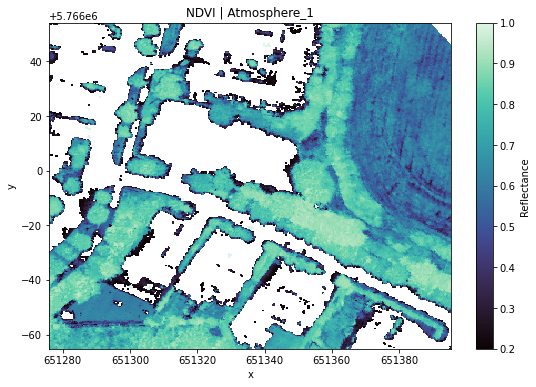

In [9]:
IR = im.sel(wavelength=827, method='nearest')
R = im.sel(wavelength=628, method='nearest')
NDVI = (IR - R) / (IR + R)
NDVI.plot(size=6)
plt.savefig('TreeView_plots/6A_NDVI_unfiltered.png')
plt.title('NDVI | Atmosphere_1')
NDVI.where(NDVI>.2).plot(cmap='mako', size=6)
plt.savefig('TreeView_plots/6_NDVI_filtered.png')
plt.title('NDVI | Atmosphere_1')


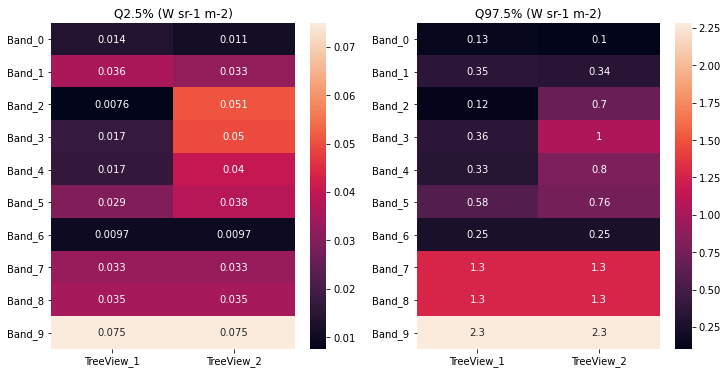

In [10]:
mask = NDVI>.2
BII_2 = []
# for s in [TreeView_1(), TreeView_2(), Sentinel2VNIR(), SuperDove()]:
#     BII_2.append(s.transform(TOA).where(NDVI>.2))
    
for s in [TreeView_1(), TreeView_2()]:
    BII_2.append(s.transform(TOA).where(NDVI>.2))
    
# BII_2 = xarray.concat(BII_2, dim='sensor').assign_coords({'sensor':['TreeView_1',
#                                                                 'TreeView_2',
#                                                                 'Sentinel_2',
#                                                                 'Super_Dove']})

BII_2 = xarray.concat(BII_2, dim='sensor').assign_coords({'sensor':['TreeView_1',
                                                                'TreeView_2']})


BII_2 = BII.assign_coords({'band':alt_bnames})
BII_2 = BII_2.where(mask)
f, ax=plt.subplots(ncols=2,figsize=(12,6))
seaborn.heatmap(BII_2.quantile(.025, ['x','y','scenario']).to_pandas().T,ax=ax[0], annot=True)
ax[0].set_title('Q2.5% (W sr-1 m-2)')
ax[0].set_ylabel('')
ax[0].set_xlabel('')

seaborn.heatmap(BII_2.quantile(.975, ['x','y','scenario']).to_pandas().T, ax=ax[1], annot=True)
ax[1].set_title('Q97.5% (W sr-1 m-2)')
ax[1].set_ylabel('')
ax[1].set_xlabel('')

plt.savefig('TreeView_plots/7_minMaxVeg_radiance.png')

## 5. Sensor specifications

In [11]:
import yaml
from pyeosim.sensor import TCMOS_test, TeledyneCMOS
sensor_configs = yaml.load(open('sensors.yaml', 'r'), Loader=yaml.Loader)

def SNR(sim_name, quantiles=[.025, .975], NDVI_thresh=0.2, levels=100, repeats=10000):
    s1 = TCMOS_test(**sensor_configs[sim_name])
    mins = TOA.where(NDVI > .2).quantile(quantiles[0], ['x','y', 'scenario'], skipna=True).values
    maxs = TOA.where(NDVI > .2).quantile(quantiles[1], ['x','y', 'scenario'], skipna=True).values

    bands = TOA.wavelength.values
    bindex = np.arange(len(bands))
    radiance_tvals = np.zeros((len(bands),levels))
    for _min, _max, i in zip(mins, maxs, bindex):
        radiance_tvals[i, :] = np.linspace(_min, _max, levels)

    rad_tvals = xarray.DataArray(np.repeat(radiance_tvals[..., np.newaxis], repeats, axis=2),
                                      coords=[('wavelength', bands),
                                              ('x', np.arange(levels)),
                                              ('y', np.arange(repeats))])

    s1_snr = s1.fit_transform(rad_tvals)
    s1_snr = s1_snr.where(s1_snr < (2**12)-1)
    return (s1_snr.mean('y', skipna=False)/s1_snr.std('y', skipna=False)).fillna(-1)

### MSI Channel simulations

In [12]:
tv1_16 = SNR('TreeView_1_MSI_16')
tv1_32 = SNR('TreeView_1_MSI_32')
tv2_16 = SNR('TreeView_2_MSI_16')
tv2_32 = SNR('TreeView_2_MSI_32')

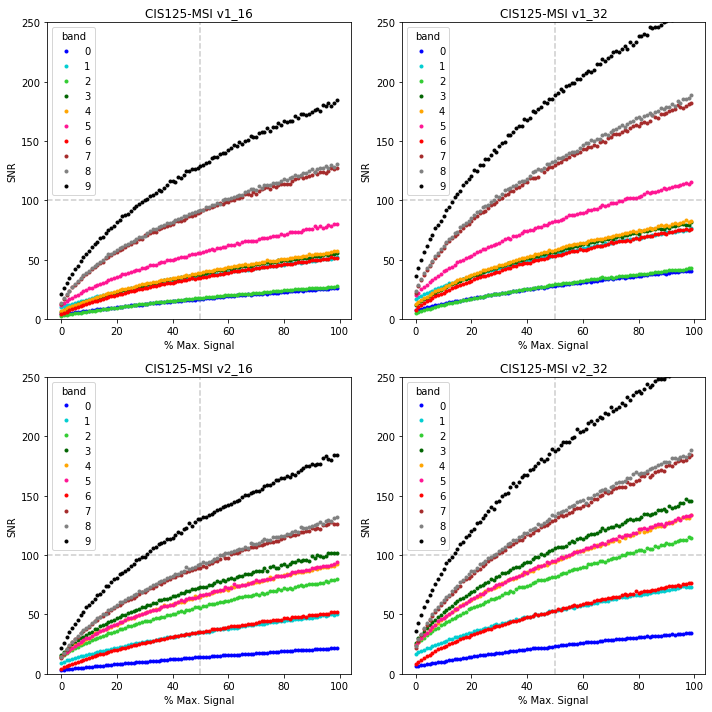

In [62]:
f, ax = plt.subplots(2,2, figsize=(10,10))
ax = ax.flat
# common params
for _ax in ax:
    _ax.axhline(100, linestyle='--', c='k', alpha=.2)
    _ax.axvline(50, linestyle='--', c='k', alpha=.2)
    _ax.set_ylim(0, 250)
    _ax.set_prop_cycle(color=cmap1)

tv1_16.plot.line(hue='band', marker='.', linestyle='', ax=ax[0])
ax[0].set_title('CIS125-MSI v1_16')

tv1_32.plot.line(hue='band', marker='.', linestyle='', ax=ax[1])
ax[1].set_title('CIS125-MSI v1_32')

tv2_16.plot.line(hue='band', marker='.', linestyle='', ax=ax[2])
ax[2].set_title('CIS125-MSI v2_16')

tv2_32.plot.line(hue='band', marker='.', linestyle='', ax=ax[3])
ax[3].set_title('CIS125-MSI v2_32')

for _ax in ax:
    _ax.set_ylabel('SNR')
    _ax.set_xlabel('% Max. Signal')

plt.tight_layout()
plt.savefig('TreeView_plots/8_SNR_MSI.png')

In [14]:
sim_name = 'TreeView_2_MSI_32'
_sensor = TeledyneCMOS(**sensor_configs[sim_name])
sim1 = _sensor.fit_transform(TOA)
# simulate an image
veg_mask_2m = NDVI.interp(x=sim1.x.values, y=sim1.y)
veg_mask_2m = veg_mask_2m > .2

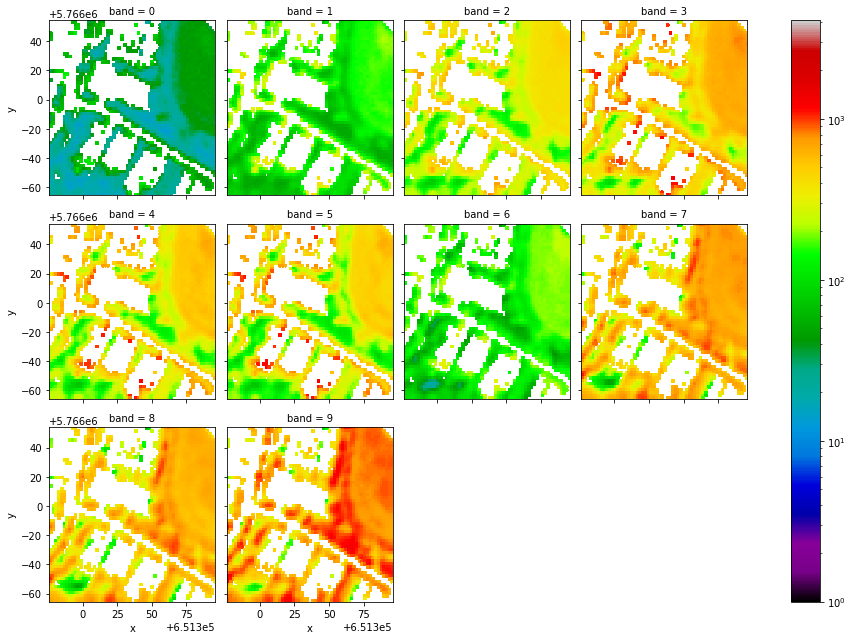

In [15]:
sim1.where(veg_mask_2m).isel(scenario=6).plot(col='band', col_wrap=4, norm=LogNorm(vmin=1, vmax=(2**12)-1), cmap='nipy_spectral')
plt.savefig('TreeView_plots/9_SceneA_brightest_MSI.png')

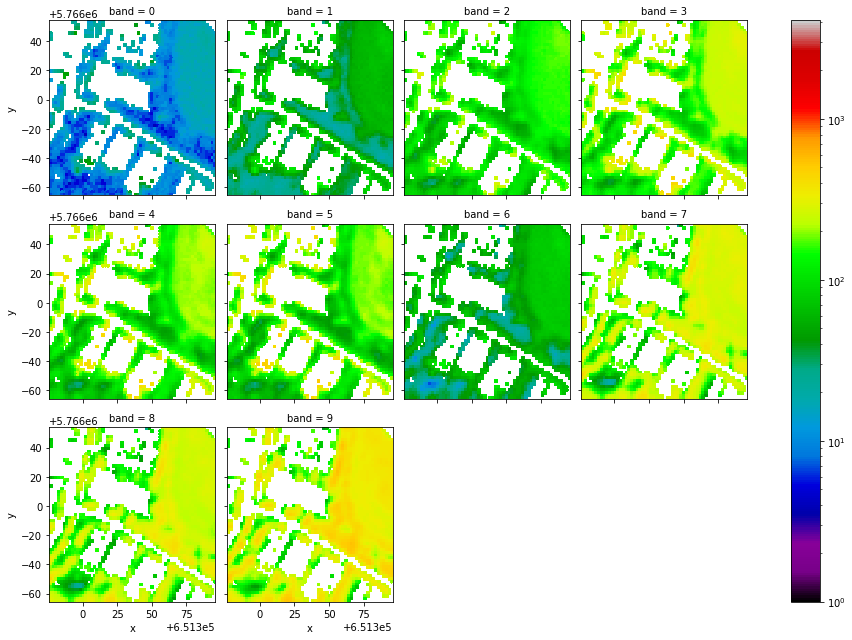

In [16]:
sim1.where(veg_mask_2m).isel(scenario=2).plot(col='band', col_wrap=4, norm=LogNorm(vmin=1, vmax=(2**12)-1), cmap='nipy_spectral', )
plt.savefig('TreeView_plots/9_SceneA_darkest_MSI.png')

### PAN Channel simulations

In [17]:
tv1_32_pan = SNR('TreeView_1_PAN_32')
tv1_64_pan = SNR('TreeView_1_PAN_64')
tv2_32_pan = SNR('TreeView_2_PAN_32')
tv2_64_pan = SNR('TreeView_2_PAN_64')

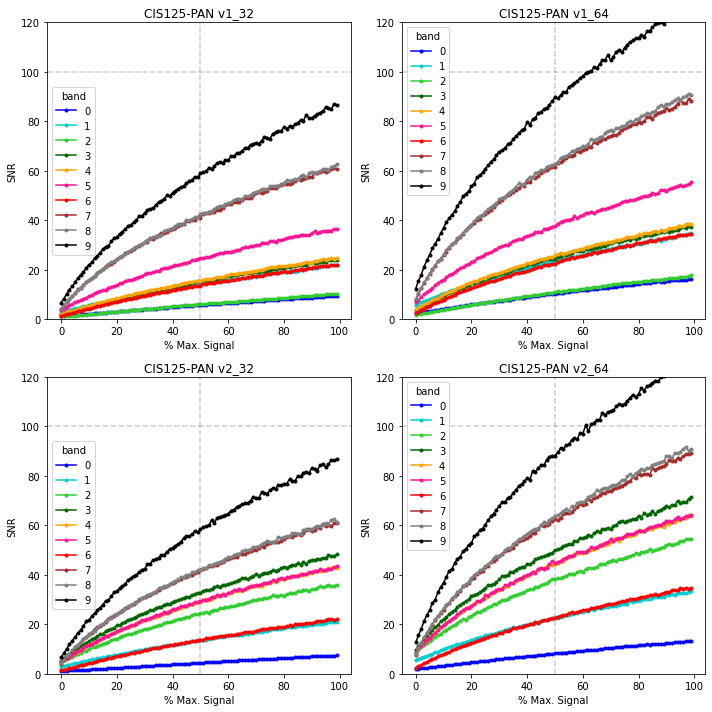

In [63]:
f, ax = plt.subplots(2,2, figsize=(10,10))
ax = ax.flat

# common params
for _ax in ax:
    _ax.axhline(100, linestyle='--', c='k', alpha=.2)
    _ax.axvline(50, linestyle='--', c='k', alpha=.2)
    _ax.set_ylim(0, 120)
    _ax.set_prop_cycle(color=cmap1)


    
tv1_32_pan.plot.line(hue='band', marker='.', ax=ax[0])
ax[0].set_title('CIS125-PAN v1_32')

tv1_64_pan.plot.line(hue='band', marker='.', ax=ax[1])
ax[1].set_title('CIS125-PAN v1_64')

tv2_32_pan.plot.line(hue='band', marker='.', ax=ax[2])
ax[2].set_title('CIS125-PAN v2_32')

tv2_64_pan.plot.line(hue='band', marker='.', ax=ax[3])
ax[3].set_title('CIS125-PAN v2_64')

for _ax in ax:
    _ax.set_ylabel('SNR')
    _ax.set_xlabel('% Max. Signal')

plt.tight_layout()
plt.savefig('TreeView_plots/10_SNR_PAN.png')

In [19]:
sim_name = 'TreeView_2_PAN_64'
_sensor = TeledyneCMOS(**sensor_configs[sim_name])
sim2 = _sensor.fit_transform(TOA)

In [20]:
veg_mask_1m = NDVI.interp(x=sim2.x.values, y=sim2.y.values)
veg_mask_1m = veg_mask_1m > .2

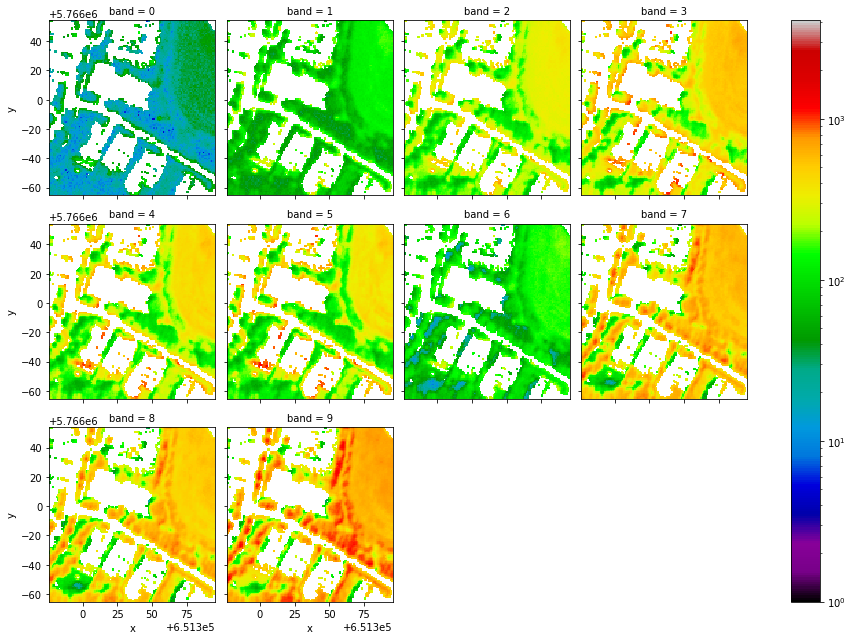

In [21]:
sim2.where(veg_mask_1m).isel(scenario=6).plot(col='band', col_wrap=4, norm=LogNorm(vmin=1, vmax=(2**12)-1), cmap='nipy_spectral', )
plt.savefig('TreeView_plots/11_SceneA_brightest_MSI.png')

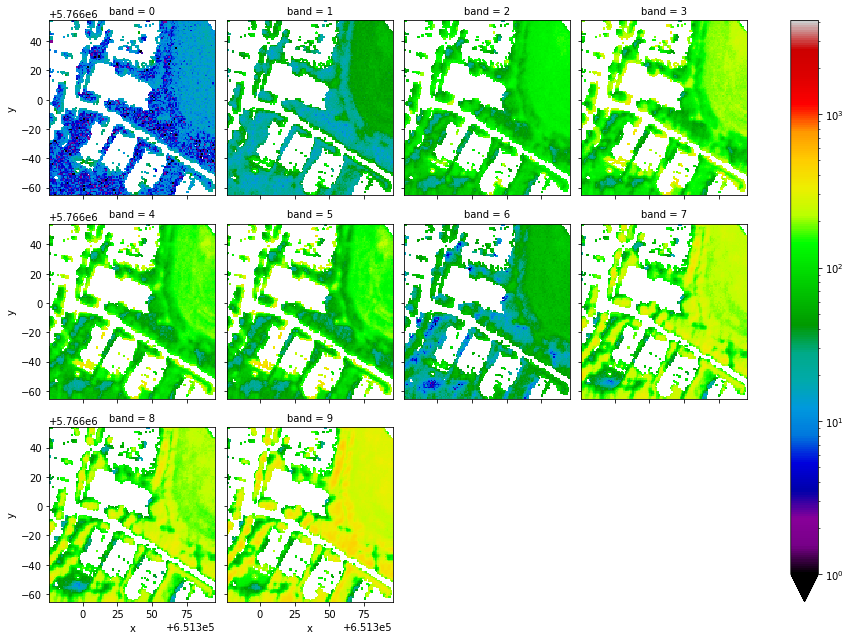

In [22]:
sim2.where(veg_mask_1m).isel(scenario=2).plot(col='band', col_wrap=4, norm=LogNorm(vmin=1, vmax=(2**12)-1), cmap='nipy_spectral', )
plt.savefig('TreeView_plots/11_SceneA_darkest_MSI.png')

## Write sensor params to tex table

In [49]:
out = {}
for name,_c in sensor_configs.items():
    _s = TeledyneCMOS(**_c)
    _s.fit(TOA)
    _n = name.replace('TreeView_', '')
    out[_n] = _s.get_params()

In [52]:
outdf = pd.DataFrame(out).drop(['spectral_response', 'Q_E', 'quantum_efficiency'])
with open('TreeView_data/sensor_params_1.tex', 'w') as f:
    f.write(outdf.to_latex(label='tab:sim_params', caption='Sensor simulation parameters used in study'))